SGNN: Supervised Graph Neural Network, A Simple Example of Supervised Learning with GNN

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

In [4]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root='data/ESOL', name="ESOL")

# print("Dataset type: ", type(data))
# print("Dataset features: ", data.num_features)
# print("Dataset target: ", data.num_classes)
# print("Dataset length: ", data.len)
# print("Dataset sample: ", data[0])
# print("Sample  nodes: ", data[0].num_nodes)
# print("Sample  edges: ", data[0].num_edges)

# print(data[0].x)

# print(data[0].edge_index.t())

# print(data[0].y)

In [5]:
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [6]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665949821472168
Epoch 100 | Train Loss 0.8516251444816589
Epoch 200 | Train Loss 1.1277498006820679
Epoch 300 | Train Loss 0.3167707622051239
Epoch 400 | Train Loss 0.22325825691223145
Epoch 500 | Train Loss 0.3700064420700073
Epoch 600 | Train Loss 0.2647426724433899
Epoch 700 | Train Loss 0.05910223349928856
Epoch 800 | Train Loss 0.15211473405361176
Epoch 900 | Train Loss 0.15682663023471832
Epoch 1000 | Train Loss 0.07054992765188217
Epoch 1100 | Train Loss 0.0557834655046463
Epoch 1200 | Train Loss 0.10662200301885605
Epoch 1300 | Train Loss 0.046556223183870316
Epoch 1400 | Train Loss 0.02827616035938263
Epoch 1500 | Train Loss 0.02172246016561985
Epoch 1600 | Train Loss 0.040180105715990067


KeyboardInterrupt: 

In [10]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

In [8]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-5.115,-6.584544
1,-0.670,-0.489446
2,0.790,0.025579
3,-1.140,-0.748182
4,-0.400,-0.998495
...,...,...
59,-1.300,-1.547505
60,-1.680,-0.358838
61,-2.090,-1.722663
62,-5.160,-4.352502


<Axes: xlabel='y_real', ylabel='y_pred'>

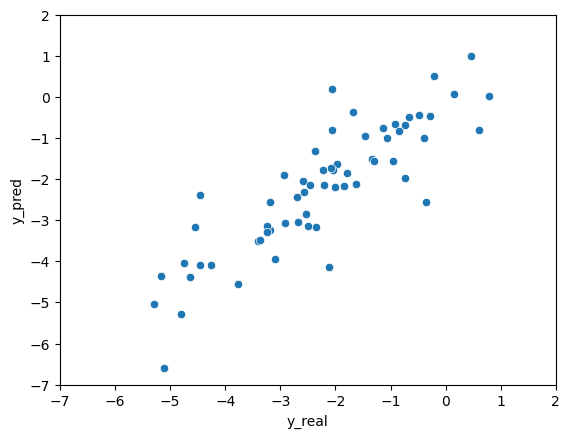

In [11]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt